In [84]:
# simulate_panel.py
import math
import numpy as np
import pandas as pd
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, Optional


In [85]:

import numpy as np
import pandas as pd

# ---- knobs ----
CS_N = 100_000
CS_YEAR = 2019
SEED = 123
rng = np.random.default_rng(SEED)

# ---- read inputs (exact files from your folder) ----
cont = pd.read_csv("data/input/simple_params/cs_2019_continuous_summary.csv")        # var, N, mean, sd, p1, p25, p50, p75, p99
freq_county = pd.read_csv("data/input/simple_params/cs_2019_freq_county.csv")        # e.g., county, freq
freq_owner  = pd.read_csv("data/input/simple_params/cs_2019_freq_firm_owner.csv")    # e.g., ownership, freq
freq_n2     = pd.read_csv("data/input/simple_params/cs_2019_freq_nace2.csv")
freq_n3     = pd.read_csv("data/input/simple_params/cs_2019_freq_nace3.csv")
freq_n4     = pd.read_csv("data/input/simple_params/cs_2019_freq_nace4.csv")

# ---- helper to build a categorical sampling vector from a freq table ----
def _mk_probs(tab):
    # first non-`freq` column = category
    cat_col = [c for c in tab.columns if c.lower() != "freq"][0]
    t = tab[[cat_col, "freq"]].dropna().copy()
    t["freq"] = t["freq"].clip(lower=0)
    p = t["freq"].to_numpy(dtype=float)
    p = p / p.sum() if p.sum() > 0 else np.ones(len(t))/len(t)
    return cat_col, t[cat_col].astype(str).to_numpy(), p

cat_c, county_vals, county_p = _mk_probs(freq_county)
cat_o, owner_vals,  owner_p  = _mk_probs(freq_owner)
cat_n2, n2_vals,     n2_p    = _mk_probs(freq_n2)
cat_n3, n3_vals,     n3_p    = _mk_probs(freq_n3)
cat_n4, n4_vals,     n4_p    = _mk_probs(freq_n4)

# ---- frame with IDs + categories ----
df = pd.DataFrame({
    "firm_id": np.arange(1, CS_N+1, dtype=int),
    "year": CS_YEAR,
    "county": rng.choice(county_vals, size=CS_N, p=county_p),
    "firm_owner": rng.choice(owner_vals, size=CS_N, p=owner_p),
    "nace2": rng.choice(n2_vals, size=CS_N, p=n2_p),
    "nace3": rng.choice(n3_vals, size=CS_N, p=n3_p),
    "nace4": rng.choice(n4_vals, size=CS_N, p=n4_p),
})

# ---- draw every continuous variable listed in `cont` ----
for _, row in cont.iterrows():
    v = str(row["var"])
    mu = float(row["mean"]) if pd.notna(row["mean"]) else 0.0
    sd = float(row["sd"])   if (pd.notna(row["sd"]) and row["sd"]>0) else 1.0
    x  = rng.normal(mu, sd, size=CS_N)
    # soft clip to [p1, p99] if available (privacy-safe range)
    lo = float(row["p1"])  if pd.notna(row.get("p1", np.nan))  else None
    hi = float(row["p99"]) if pd.notna(row.get("p99", np.nan)) else None
    if lo is not None and hi is not None:
        x = np.clip(x, min(lo,hi), max(lo,hi))
    # integerize employment-like names
    if v.lower() in {"employment","emp","headcount","fte"}:
        x = np.clip(np.round(x), 1, None).astype(int)
    df[v] = x

# ---- minimal composites if both present ----
if {"pm","sales_clean"}.issubset(df.columns):
    df["profit_1000HUF"] = df["pm"] * df["sales_clean"]

# ---- save: raw (HU names) + optional English mapping if possible ----
df.to_parquet("data/synthetic/synthetic_cs2019_distributions_only.parquet", index=False)

# Optional mapping (only if source columns exist)
name_map = {
    "sales_clean": "sales_1000HUF",
    "persexp_clean": "personal_expenses_1000HUF",
    "tanass_clean": "tangible_assets_1000HUF",
    "satok": "eq_ratio",
    "pretax": "profit_1000HUF",
    "ereduzem": "EBIT_1000HUF",
    "export": "export_value_1000HUF",
}
df_out = df.copy()
for src, tgt in name_map.items():
    if src in df_out.columns:
        df_out.rename(columns={src: tgt}, inplace=True)
df_out.to_parquet("data/synthetic/synthetic_cs2019_distributions_only_stdnames.parquet", index=False)

df_out.head()

,firm_id,year,county,firm_owner,nace2,nace3,nace4,age,tangible_assets_1000HUF,sales_1000HUF,profit_1000HUF,personal_expenses_1000HUF,eq_ratio,export_value_1000HUF,EBIT_1000HUF,emp
0,1,2019,5.0,domestic,46.0,469,6820,13.396271,0.0,2788139.53,267371.88,0.00,1541733.4,0.00,239179.60,81
1,2,2019,1.0,domestic,90.0,412,1812,20.861739,1084577.8,0.00,267371.88,365606.67,1541733.4,41417.13,-31135.34,63
2,3,2019,1.0,foreign,70.0,683,4751,11.466051,0.0,2788139.53,267371.88,0.00,-39809.0,0.00,239179.60,81
3,4,2019,1.0,domestic,68.0,639,6810,11.327155,0.0,0.00,267371.88,365606.67,-39809.0,0.00,-31135.34,81
4,5,2019,1.0,domestic,45.0,469,4941,0.000000,0.0,0.00,-35146.83,365606.67,-39809.0,0.00,239179.60,62


In [86]:
df_out.shape

(100000, 16)

In [87]:
CS_N = 100_000
CS_YEAR = 2019
SEED = 321
rng = np.random.default_rng(SEED)

# ---- load base draws from Version A to ensure all regressors exist ----
base = pd.read_parquet("data/synthetic/synthetic_cs2019_distributions_only.parquet")  # produced by the previous cell
assert len(base) == CS_N, "Run Version A first to create the base frame."

df = base.copy()

# ---- read all sequential regression files present ----
seq_files = {
    "sales_clean": "data/input/simple_params/cs_2019_seq_lm_sales_clean.csv",
    "satok":       "data/input/simple_params/cs_2019_seq_lm_satok.csv",
    "tanass_clean":"data/input/simple_params/cs_2019_seq_lm_tanass_clean.csv",
    "persexp_clean":"data/input/simple_params/cs_2019_seq_lm_persexp_clean.csv",
    "export":      "data/input/simple_params/cs_2019_seq_lm_export.csv",
    "pretax":      "data/input/simple_params/cs_2019_seq_lm_pretax.csv",
    "ereduzem":    "data/input/simple_params/cs_2019_seq_lm_ereduzem.csv",
}
seq_coefs = {}
for dep, fn in seq_files.items():
    try:
        seq_coefs[dep] = pd.read_csv(fn)
    except Exception:
        seq_coefs[dep] = None  # we'll keep the base draw for that var

# ---- distribution table to set residual scale & clipping per variable ----
cont = pd.read_csv("data/input/simple_params/cs_2019_continuous_summary.csv")
dist_info = {str(r["var"]): dict(mean=float(r["mean"]), sd=float(r["sd"]),
                                 p1=float(r["p1"]) if pd.notna(r["p1"]) else None,
                                 p99=float(r["p99"]) if pd.notna(r["p99"]) else None)
             for _, r in cont.iterrows()}

# ---- apply each sequential regression in a stable order ----
# If you have an explicit order (e.g., from cs_2019_seq_overview.csv), you can read it and sort.
# Here we use the order in seq_files above.
for dep, coef_df in seq_coefs.items():
    if coef_df is None:
        continue
    # compute linear predictor
    terms = coef_df["term"].astype(str).tolist()
    betas = coef_df["estimate"].astype(float).to_numpy()
    yhat = np.zeros(len(df))
    for tname, b in zip(terms, betas):
        if tname == "(Intercept)":
            yhat += b
        elif tname in df.columns:
            yhat += b * df[tname].to_numpy()
        else:
            # unknown regressor term -> ignore safely
            pass

    # residual noise: scale to 10% of reported sd if available (small, for smoothness)
    info = dist_info.get(dep, None)
    if info is not None and np.isfinite(info["sd"]) and info["sd"] > 0:
        eps_sd = max(0.10 * info["sd"], 1e-6)
    else:
        eps_sd = 0.1
    y = yhat + rng.normal(0, eps_sd, size=len(df))

    # clip to [p1,p99] if available
    if info is not None and (info["p1"] is not None) and (info["p99"] is not None):
        y = np.clip(y, min(info["p1"], info["p99"]), max(info["p1"], info["p99"]))

    # integerize if this is employment-like
    if dep.lower() in {"employment","emp","headcount","fte"}:
        y = np.clip(np.round(y), 1, None).astype(int)

    df[dep] = y

# ---- subsidy: participation logit + amount OLS (your CSVs) ----
# 1) Participation
try:
    part = pd.read_csv("data/input/simple_params/cs_2019_subsidy_participation_logit.csv")  # columns: term, estimate, ...
    lin = np.zeros(len(df))
    for _, r in part.iterrows():
        term = str(r["term"]); b = float(r["estimate"])
        if term == "(Intercept)":
            lin += b
        elif term in df.columns:
            lin += b * df[term].to_numpy()
        # else: silently ignore unknown terms
    p = 1.0 / (1.0 + np.exp(-lin))
    has_subsidy = (rng.uniform(size=len(df)) < p)
except Exception:
    # fallback: small flat rate
    has_subsidy = rng.uniform(size=len(df)) < 0.10

df["has_subsidy"] = has_subsidy.astype(int)

# 2) Amount among recipients
try:
    amt = pd.read_csv("data/input/simple_params/cs_2019_subsidy_amount_ols.csv")  # term, estimate, ...
    yhat = np.zeros(len(df))
    for _, r in amt.iterrows():
        term = str(r["term"]); b = float(r["estimate"])
        if term == "(Intercept)":
            yhat += b
        elif term in df.columns:
            yhat += b * df[term].to_numpy()
    # residual scale: proxy from yhat dispersion
    res_sd = max(0.2 * np.nanstd(yhat), 1.0)
    subsidy = np.zeros(len(df))
    subsidy[has_subsidy] = yhat[has_subsidy] + rng.normal(0, res_sd, size=has_subsidy.sum())
    subsidy = np.clip(subsidy, 0.0, None)
except Exception:
    subsidy = has_subsidy.astype(float) * rng.gamma(shape=2.0, scale=300.0, size=len(df))

df["subsidy_1000HUF"] = subsidy

# ---- recompute profit if both pm & sales available under your names ----
if {"pm","sales_clean"}.issubset(df.columns):
    df["profit_1000HUF"] = df["pm"] * df["sales_clean"]

# ---- save: raw (HU names) + optional standardized names where obvious ----
df.to_parquet("synthetic_cs2019_from_seq_regs.parquet", index=False)

std_map = {
    "sales_clean": "sales_1000HUF",
    "persexp_clean": "personal_expenses_1000HUF",
    "tanass_clean": "tangible_assets_1000HUF",
    "satok": "eq_ratio",
    "pretax": "profit_1000HUF",
    "ereduzem": "EBIT_1000HUF",
    "export": "export_value_1000HUF",
    "subsidy_1000HUF": "grant_1000HUF",
}
df_std = df.copy()
for src, tgt in std_map.items():
    if src in df_std.columns:
        df_std.rename(columns={src: tgt}, inplace=True)

df_std.to_parquet("data/synthetic/synthetic_cs2019_from_seq_regs_stdnames.parquet", index=False)
df_std.head()

,firm_id,year,county,firm_owner,nace2,nace3,nace4,age,tangible_assets_1000HUF,sales_1000HUF,profit_1000HUF,personal_expenses_1000HUF,eq_ratio,export_value_1000HUF,EBIT_1000HUF,emp,has_subsidy,grant_1000HUF
0,1,2019,5.0,domestic,46.0,469,6820,13.396271,760454.095536,0.000000,-35146.830000,11553.415964,5.425214e+05,0.00,-4711.302413,81,0,0.0
1,2,2019,1.0,domestic,90.0,412,1812,20.861739,217095.377350,916656.440009,129979.431646,95617.883265,5.613773e+05,41417.13,48448.638439,63,0,0.0
2,3,2019,1.0,foreign,70.0,683,4751,11.466051,389908.252210,0.000000,267371.880000,131892.179100,-3.980900e+04,41417.13,23173.010584,81,0,0.0
3,4,2019,1.0,domestic,68.0,639,6810,11.327155,494233.617096,0.000000,172601.620537,9196.396489,1.541733e+06,41417.13,7895.891652,81,0,0.0
4,5,2019,1.0,domestic,45.0,469,4941,0.000000,0.000000,0.000000,201022.867173,130752.674062,1.991992e+05,0.00,130.916426,62,0,0.0


<Axes: >

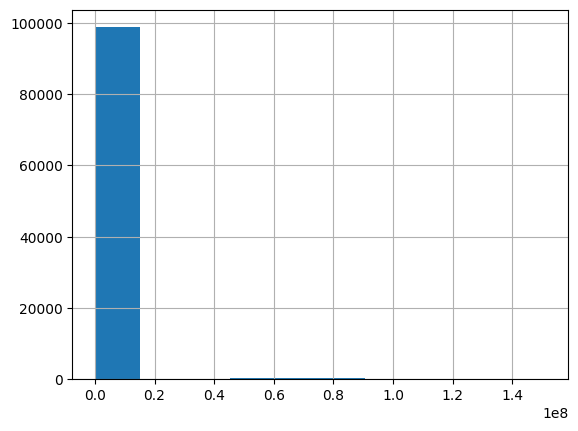

In [88]:
df_std["grant_1000HUF"].hist()

## Food panel

In [89]:


SEED = 123
rng = np.random.default_rng(SEED)

BASE_YEAR = 2010
LAST_YEAR = 2022
DEFAULT_N_PER_YEAR =3500  # used if yearly N not provided

# Variable names (final simulated columns)
sales   = "sales_clean"
emp     = "emp"
totA    = "eszk"
tanA    = "tanass_clean"
persE   = "persexp_clean"
pm      = "pm"
profit  = "pretax"
ebit    = "ereduzem"
exportv = "export"
exporter= "has_export"
county  = "county"
owner   = "firm_owner"
ind2    = "nace2"


In [90]:
cs2010_init = pd.read_csv("data/input/simple_params/cs2010_init.csv")                    # varname, mean, sd
cs2010_corr = pd.read_csv("data/input/simple_params/cs2010_corr_matrix.csv", index_col=0)

county_shares = pd.read_csv("data/input/simple_params/county_shares_2010.csv")           # county, share2010
owner_shares  = pd.read_csv("data/input/simple_params/ownership_shares_2010.csv")        # ownership, share2010

pm_2010      = pd.read_csv("data/input/simple_params/pm_2010.csv")                       # mean/sd (level)
ebit_asinh_2010 = pd.read_csv("data/input/simple_params/ebit_asinh_2010.csv")            # mean/sd (asinh)
export_pos_2010 = pd.read_csv("data/input/simple_params/export_pos_2010.csv")            # pos_share, log_mean, log_sd

try:
    yr_sum = pd.read_csv("data/input/simple_params/panel_yearly_summary_ind10.csv")      # year, N (and maybe means)
except:
    yr_sum = None

try:
    xts = pd.read_csv("data/input/simple_params/panel_xtsum_ind10.csv")                  # var, mean_overall, sd_within, ...
except:
    xts = None

try:
    ac1 = pd.read_csv("data/input/simple_params/panel_autocorr_ind10.csv")               # var, rho
except:
    ac1 = None

In [91]:
# %% 2010 copula set-up (logs of core variables)

# The extractor wrote logs named like: ln_sales_1000HUF, ln_employment, ...
init_log_vars = cs2010_init["varname"].tolist()

mu = cs2010_init.set_index("varname")["mean"].reindex(init_log_vars).to_numpy(float)
sd = cs2010_init.set_index("varname")["sd"].reindex(init_log_vars).to_numpy(float)
sd = np.where(sd <= 0, 1e-6, sd)

C  = cs2010_corr.loc[init_log_vars, init_log_vars].to_numpy(float)
Sigma0 = np.diag(sd) @ C @ np.diag(sd)

# Shares for county & ownership
county_vals = county_shares["county"].astype(str).to_numpy()
county_p = county_shares["share2010"].to_numpy()
county_p = county_p / county_p.sum()

owner_vals = owner_shares["ownership"].astype(str).to_numpy()
owner_p = owner_shares["share2010"].to_numpy()
owner_p = owner_p / owner_p.sum()

# pm and EBIT seeds
pm_mean = float(pm_2010.loc[pm_2010["var"]==pm, "mean"].iloc[0]) if "var" in pm_2010.columns else float(pm_2010["mean"].iloc[0])
pm_sd   = float(pm_2010.loc[pm_2010["var"]==pm, "sd"].iloc[0])   if "var" in pm_2010.columns else float(pm_2010["sd"].iloc[0])

eb_asinh_mean = float(ebit_asinh_2010["mean"].iloc[0])
eb_asinh_sd   = float(ebit_asinh_2010["sd"].iloc[0])

# export seed (two-part)
pos_share = float(export_pos_2010["pos_share"].iloc[0])
ex_log_mu = float(export_pos_2010["log_mean"].iloc[0])
ex_log_sd = float(export_pos_2010["log_sd"].iloc[0])


In [92]:
# %% Yearly N and AR(1) parameters

# Target N per year
if yr_sum is not None and "N" in yr_sum.columns:
    N_by_year = {int(r["year"]): int(r["N"]) for _, r in yr_sum.iterrows()}
else:
    N_by_year = {y: DEFAULT_N_PER_YEAR for y in range(BASE_YEAR, LAST_YEAR+1)}

# Lag-1 autocorr (rho) by variable
def rho_for(varname, default=0.7):
    if ac1 is None or "var" not in ac1.columns or "rho" not in ac1.columns:
        return default
    m = ac1[ac1["var"] == varname]
    return float(m["rho"].iloc[0]) if len(m) else default

rho_lnS = rho_for(f"ln_{sales}", default=0.8)
rho_lnE = rho_for(f"ln_{emp}",   default=0.8)

# Within SD (approx) to back out innovation SD: sigma_eps = sd_within * sqrt(1 - rho^2)
def within_sd(varname, default=0.3):
    if xts is None or "var" not in xts.columns:
        return default
    row = xts[xts["var"] == varname]
    if len(row) == 0:
        return default
    # prefer sd_within if present; else sd_overall
    for col in ["sd_within","sd_overall","sd"]:
        if col in row.columns and pd.notna(row[col].iloc[0]):
            return float(row[col].iloc[0])
    return default

sdw_lnS = within_sd(f"ln_{sales}", default=0.9)
sdw_lnE = within_sd(f"ln_{emp}",   default=0.6)

sig_eps_lnS = sdw_lnS * math.sqrt(max(0.0, 1.0 - rho_lnS**2))
sig_eps_lnE = sdw_lnE * math.sqrt(max(0.0, 1.0 - rho_lnE**2))

# Cholesky for correlated shocks (assume some correlation; if you have a 2x2 residual matrix, plug it here)
resid_corr = 0.3
Sigma_eps = np.array([[sig_eps_lnS**2, resid_corr*sig_eps_lnS*sig_eps_lnE],
                      [resid_corr*sig_eps_lnS*sig_eps_lnE, sig_eps_lnE**2]])
L_eps = np.linalg.cholesky(Sigma_eps)

# Simple rhos for other logs; fall back to 0.6 if missing
rho_lnA  = rho_for(f"ln_{totA}", default=0.6)
rho_lnTA = rho_for(f"ln_{tanA}", default=0.6)
rho_lnPE = rho_for(f"ln_{persE}", default=0.6)

sdw_lnA  = within_sd(f"ln_{totA}", default=0.6);  sig_eps_lnA  = sdw_lnA  * math.sqrt(max(0.0, 1.0 - rho_lnA**2))
sdw_lnTA = within_sd(f"ln_{tanA}", default=0.6);  sig_eps_lnTA = sdw_lnTA * math.sqrt(max(0.0, 1.0 - rho_lnTA**2))
sdw_lnPE = within_sd(f"ln_{persE}", default=0.6); sig_eps_lnPE = sdw_lnPE * math.sqrt(max(0.0, 1.0 - rho_lnPE**2))

# pm (level) and ebit (asinh) AR(1)
rho_pm    = rho_for(pm,    default=0.5)
rho_asinh = rho_for(ebit,  default=0.6)
sdw_pm    = within_sd(pm,  default=pm_sd)   # rough fallback
sdw_asinh = within_sd(ebit, default=eb_asinh_sd)
sig_eps_pm    = sdw_pm    * math.sqrt(max(0.0, 1.0 - rho_pm**2))
sig_eps_asinh = sdw_asinh * math.sqrt(max(0.0, 1.0 - rho_asinh**2))


In [93]:
# %% Seed 2010 cohort

N0 = N_by_year.get(BASE_YEAR, DEFAULT_N_PER_YEAR)

Z0 = rng.multivariate_normal(mu, Sigma0, size=N0)
df0 = pd.DataFrame(Z0, columns=init_log_vars)

# Levels for core logs
df0[sales] = np.exp(df0[f"ln_{sales}"])
df0[emp]   = np.clip(np.round(np.exp(df0[f"ln_{emp}"])), 1, None).astype(int)
df0[totA]  = np.exp(df0[f"ln_{totA}"])
df0[tanA]  = np.exp(df0[f"ln_{tanA}"])
df0[persE] = np.exp(df0[f"ln_{persE}"])

# pm (level) and EBIT (asinh) from seed
df0[pm]   = np.clip(rng.normal(pm_mean, max(1e-6, pm_sd), size=N0), -0.6, 0.6)
asinh0    = rng.normal(eb_asinh_mean, max(1e-6, eb_asinh_sd), size=N0)
df0[ebit] = np.sinh(asinh0)

# export two-part
has_exp0 = rng.uniform(size=N0) < pos_share
df0[exportv] = 0.0
ln_expv0 = rng.normal(ex_log_mu, max(1e-6, ex_log_sd), size=N0)
df0.loc[has_exp0, exportv] = np.exp(ln_expv0[has_exp0])
# exporter dummy: treat positive exports as exporter=1
df0[exporter] = has_exp0.astype(int)

# profit
df0[profit] = df0[pm] * df0[sales]

# county & ownership
df0[county] = rng.choice(county_vals, size=N0, p=county_p)
df0[owner]  = rng.choice(owner_vals,  size=N0, p=owner_p)

# ids, year, industry
df0["firm_id"] = np.arange(1, N0+1, dtype=int)
df0["year"] = BASE_YEAR
df0[ind2] = "10"

df0.head()


,ln_sales_clean,ln_emp,ln_eszk,ln_tanass_clean,ln_persexp_clean,sales_clean,emp,eszk,tanass_clean,persexp_clean,pm,ereduzem,export,has_export,pretax,county,firm_owner,firm_id,year,nace2
0,21.139436,7.352908,7.107043,7.074103,12.206257,1.516144e+09,1561,1220.533535,1.180983e+03,2.000368e+05,0.107471,-1.141187e+00,0.0,0,1.629416e+08,9,domestic,1,2010,10
1,0.819432,-6.068244,7.800433,1.070865,3.620158,2.269209e+00,1,2441.658286,2.917902e+00,3.734348e+01,-0.018912,-6.204777e+01,0.0,0,-4.291515e-02,10,domestic,2,2010,10
2,6.175818,3.347998,4.199131,-0.941060,2.941912,4.809763e+02,28,66.628408,3.902138e-01,1.895206e+01,0.173781,9.923603e+11,0.0,0,8.358458e+01,16,domestic,3,2010,10
3,8.323971,-11.423427,11.603032,16.290406,6.699234,4.121493e+03,1,109429.075344,1.188047e+07,8.117836e+02,-0.299327,-1.718867e+01,0.0,0,-1.233675e+03,4,foreign,4,2010,10
4,38.093307,12.216790,10.302978,15.016757,22.433836,3.497139e+16,202155,29821.288997,3.324257e+06,5.532113e+09,-0.005062,-2.509658e+01,0.0,0,-1.770156e+14,13,domestic,5,2010,10


In [94]:
# %% Iterate years with AR(1) dynamics and entrants to hit yearly N

frames = [df0.copy()]
max_id = df0["firm_id"].max()

for t in range(BASE_YEAR+1, LAST_YEAR+1):
    prev = frames[-1].copy()

    # Survival: keep a constant rate implied by N targets (approx).
    # Compute needed survivors to meet expected N before entrants.
    target_N = N_by_year.get(t, DEFAULT_N_PER_YEAR)
    # Try a flat survival fraction ~ min(0.98, N_t / N_{t-1}) as heuristic
    surv_frac = min(0.98, target_N / max(1, len(prev)))
    alive = rng.uniform(size=len(prev)) < surv_frac
    cur = prev.loc[alive].copy().reset_index(drop=True)

    # Entrants to fill up to target N
    need = max(0, target_N - len(cur))
    if need > 0:
        Z_ent = rng.multivariate_normal(mu, Sigma0, size=need)
        ent = pd.DataFrame(Z_ent, columns=init_log_vars)
        ent[sales] = np.exp(ent[f"ln_{sales}"])
        ent[emp]   = np.clip(np.round(np.exp(ent[f"ln_{emp}"])), 1, None).astype(int)
        ent[totA]  = np.exp(ent[f"ln_{totA}"])
        ent[tanA]  = np.exp(ent[f"ln_{tanA}"])
        ent[persE] = np.exp(ent[f"ln_{persE}"])
        ent[pm]    = np.clip(rng.normal(pm_mean, max(1e-6, pm_sd), size=need), -0.6, 0.6)
        asinh_ent  = rng.normal(eb_asinh_mean, max(1e-6, eb_asinh_sd), size=need)
        ent[ebit]  = np.sinh(asinh_ent)
        pos_ent    = rng.uniform(size=need) < pos_share
        ent[exportv] = 0.0
        ln_expv_ent = rng.normal(ex_log_mu, max(1e-6, ex_log_sd), size=need)
        ent.loc[pos_ent, exportv] = np.exp(ln_expv_ent[pos_ent])
        ent[exporter] = pos_ent.astype(int)
        ent[profit] = ent[pm] * ent[sales]
        ent[county] = rng.choice(county_vals, size=need, p=county_p)
        ent[owner]  = rng.choice(owner_vals,  size=need, p=owner_p)
        ent["firm_id"] = np.arange(max_id+1, max_id+need+1, dtype=int)
        ent[ind2] = "10"
        ent["year"] = t
        max_id += need
        cur = pd.concat([cur, ent], ignore_index=True)

    # AR(1) for ln(sales) and ln(emp) with correlated shocks
    lnS_prev = np.log(cur[sales].clip(1e-12).to_numpy())
    lnE_prev = np.log(np.clip(cur[emp].to_numpy(), 1, None))

    Z = rng.normal(size=(len(cur),2)) @ L_eps.T
    lnS_t = rho_lnS * lnS_prev + Z[:,0]
    lnE_t = rho_lnE * lnE_prev + Z[:,1]

    cur[sales] = np.exp(lnS_t)
    cur[emp]   = np.clip(np.round(np.exp(lnE_t)), 1, None).astype(int)

    # AR(1) for other logs (independent shocks for simplicity)
    lnA_prev  = np.log(cur[totA].clip(1e-12))
    lnTA_prev = np.log(cur[tanA].clip(1e-12))
    lnPE_prev = np.log(cur[persE].clip(1e-12))

    lnA_t  = rho_lnA  * lnA_prev  + rng.normal(0, sig_eps_lnA,  size=len(cur))
    lnTA_t = rho_lnTA * lnTA_prev + rng.normal(0, sig_eps_lnTA, size=len(cur))
    lnPE_t = rho_lnPE * lnPE_prev + rng.normal(0, sig_eps_lnPE, size=len(cur))

    cur[totA]  = np.exp(lnA_t)
    cur[tanA]  = np.exp(lnTA_t)
    cur[persE] = np.exp(lnPE_t)

    # pm (level) AR(1) and ebit (asinh) AR(1)
    pm_prev = cur[pm].to_numpy()
    pm_t    = rho_pm * pm_prev + rng.normal(0, sig_eps_pm, size=len(cur))
    cur[pm] = np.clip(pm_t, -0.6, 0.6)

    as_prev = np.arcsinh(cur[ebit].to_numpy())
    as_t    = rho_asinh * as_prev + rng.normal(0, sig_eps_asinh, size=len(cur))
    cur[ebit] = np.sinh(as_t)

    # Exporter probability rises with size; keep two-part structure
    # Participation: size-based probability anchored at initial pos_share
    p_pos = np.clip(pos_share * np.exp(0.15*(lnE_t - np.mean(lnE_t))), 0.01, 0.99)
    pos   = rng.uniform(size=len(cur)) < p_pos
    # Conditional export value: random walk on log export value (among positives)
    ln_expv_prev = np.log(np.clip(cur[exportv].to_numpy(), 1e-12, None))
    rho_exv = 0.6
    sig_exv = 0.5
    ln_expv_t = rho_exv * ln_expv_prev + 0.2 * lnS_t + rng.normal(0, sig_exv, size=len(cur))
    cur[exportv] = 0.0
    cur.loc[pos, exportv] = np.exp(ln_expv_t[pos])
    cur[exporter] = pos.astype(int)

    # Profit from pm * sales
    cur[profit] = cur[pm] * cur[sales]

    cur["year"] = t
    frames.append(cur)

panel = pd.concat(frames, ignore_index=True)
panel[ind2] = "10"
panel.head()


C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflow encountered in sinh
  cur[ebit] = np.sinh(as_t)
C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflow encountered in sinh
  cur[ebit] = np.sinh(as_t)
C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflow encountered in sinh
  cur[ebit] = np.sinh(as_t)
C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflow encountered in sinh
  cur[ebit] = np.sinh(as_t)
C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflow encountered in sinh
  cur[ebit] = np.sinh(as_t)
C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflow encountered in sinh
  cur[ebit] = np.sinh(as_t)
C:\Users\Barabás Dániel\AppData\Local\Temp\ipykernel_35120\2572634414.py:75: RuntimeWarning: overflo

,ln_sales_clean,ln_emp,ln_eszk,ln_tanass_clean,ln_persexp_clean,sales_clean,emp,eszk,tanass_clean,persexp_clean,pm,ereduzem,export,has_export,pretax,county,firm_owner,firm_id,year,nace2
0,21.139436,7.352908,7.107043,7.074103,12.206257,1.516144e+09,1561,1220.533535,1.180983e+03,2.000368e+05,0.107471,-1.141187e+00,0.0,0,1.629416e+08,9,domestic,1,2010,10
1,0.819432,-6.068244,7.800433,1.070865,3.620158,2.269209e+00,1,2441.658286,2.917902e+00,3.734348e+01,-0.018912,-6.204777e+01,0.0,0,-4.291515e-02,10,domestic,2,2010,10
2,6.175818,3.347998,4.199131,-0.941060,2.941912,4.809763e+02,28,66.628408,3.902138e-01,1.895206e+01,0.173781,9.923603e+11,0.0,0,8.358458e+01,16,domestic,3,2010,10
3,8.323971,-11.423427,11.603032,16.290406,6.699234,4.121493e+03,1,109429.075344,1.188047e+07,8.117836e+02,-0.299327,-1.718867e+01,0.0,0,-1.233675e+03,4,foreign,4,2010,10
4,38.093307,12.216790,10.302978,15.016757,22.433836,3.497139e+16,202155,29821.288997,3.324257e+06,5.532113e+09,-0.005062,-2.509658e+01,0.0,0,-1.770156e+14,13,domestic,5,2010,10


In [95]:
# %% Save panel and quick checks

panel = panel[[
    "firm_id","year", ind2, county, owner,
    emp, sales, totA, tanA, persE, pm, profit, ebit, exporter, exportv
]]

panel.to_parquet("data/synthetic/panel_food_simulated.parquet", index=False)
panel.head(10)
print("Years:", panel["year"].min(), "-", panel["year"].max())
print("Rows per year (first 5):")
print(panel.groupby("year")["firm_id"].count().head())


Years: 2010 - 2022
Rows per year (first 5):
year
2010    3522
2011    3723
2012    3683
2013    3814
2014    3844
Name: firm_id, dtype: int64
